In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
original_df = pd.read_csv('launch_data.csv')
df = original_df.copy()

In [3]:
df.head()

,id,name,status,net,window_start,window_end,is_crewed,rocket_name,rocket_full_name,rocket_manufacturer,provider,mission_type,orbit,pad_name,location_name,location_country
0,e3df2ecd-c239-472f-95e4-2b89b4f75800,Sputnik 8K74PS | Sputnik 1,Launch Successful,1957-10-04T19:28:34Z,1957-10-04T19:28:34Z,1957-10-04T19:28:34Z,NaN,Sputnik 8K74PS,Sputnik 8K74PS,Energia,Soviet Space Program,Test Flight,Low Earth Orbit,1/5,"Baikonur Cosmodrome, Republic of Kazakhstan",NaN
1,f8c9f344-a6df-4f30-873a-90fe3a7840b3,Sputnik 8K74PS | Sputnik 2,Launch Successful,1957-11-03T02:30:00Z,1957-11-03T02:30:00Z,1957-11-03T02:30:00Z,NaN,Sputnik 8K74PS,Sputnik 8K74PS,Energia,Soviet Space Program,Test Flight,Low Earth Orbit,1/5,"Baikonur Cosmodrome, Republic of Kazakhstan",NaN
2,535c1a09-97c8-4f96-bb64-6336d4bcb1fb,Vanguard | Vanguard,Launch Failure,1957-12-06T16:44:35Z,1957-12-06T16:44:35Z,1957-12-06T16:44:35Z,NaN,Vanguard,Vanguard,Lockheed Martin,US Navy,Test Flight,Low Earth Orbit,Launch Complex 18A,"Cape Canaveral SFS, FL, USA",NaN
3,1b9e28d0-c531-44b0-9b37-244e62a6d3f4,Juno-I | Explorer 1,Launch Successful,1958-02-01T03:47:56Z,1958-02-01T03:47:56Z,1958-02-01T03:47:56Z,NaN,Juno-I,Juno-I,Chrysler,Army Ballistic Missile Agency,Test Flight,Low Earth Orbit,Launch Complex 26A,"Cape Canaveral SFS, FL, USA",NaN
4,48bc7deb-b2e1-46c2-ab63-0ce00fbd192b,Vanguard | Vanguard,Launch Failure,1958-02-05T07:33:00Z,1958-02-05T07:33:00Z,1958-02-05T07:33:00Z,NaN,Vanguard,Vanguard,Lockheed Martin,US Navy,Test Flight,Low Earth Orbit,Launch Complex 18A,"Cape Canaveral SFS, FL, USA",NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7344 non-null   object 
 1   name                 7344 non-null   object 
 2   status               7344 non-null   object 
 3   net                  7344 non-null   object 
 4   window_start         7344 non-null   object 
 5   window_end           7344 non-null   object 
 6   is_crewed            0 non-null      float64
 7   rocket_name          7344 non-null   object 
 8   rocket_full_name     7344 non-null   object 
 9   rocket_manufacturer  7344 non-null   object 
 10  provider             7344 non-null   object 
 11  mission_type         6801 non-null   object 
 12  orbit                6814 non-null   object 
 13  pad_name             7344 non-null   object 
 14  location_name        7344 non-null   object 
 15  location_country     0 non-null      f


--- Launch Market Share: Modern Era (2010 - Present) ---
        provider_type  Total Launches  Percentage
0  Commercial/Private            2091       93.52
1    Government/State             145        6.48


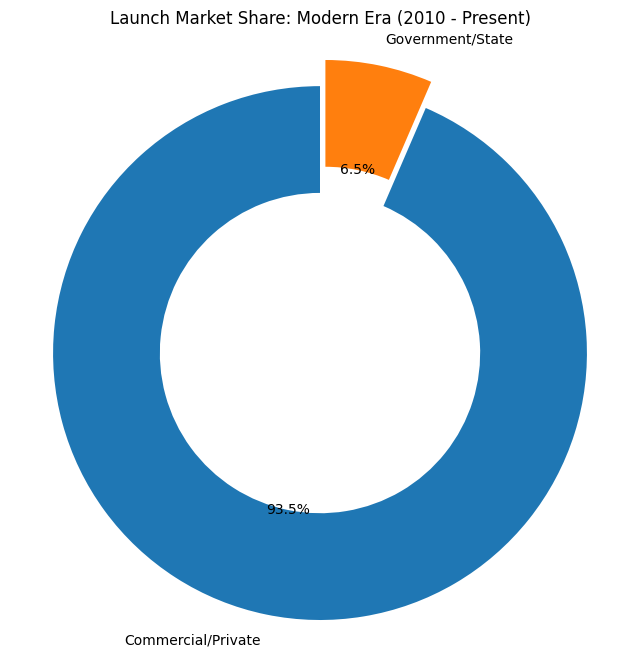

In [6]:
# --- CLEANING AND FEATURE ENGINEERING (CRUCIAL STEP) ---

# 1a. Convert the 'net' column to datetime and extract the year
df['net_datetime'] = pd.to_datetime(df['net'], utc=True)
df['launch_year'] = df['net_datetime'].dt.year

# 1b. Drop rows where we can't determine the launch date
df.dropna(subset=['net_datetime'], inplace=True)

# 1c. Feature Engineering: Provider Type (Commercialization Trend)
state_agencies = [
    'nasa', 'roscosmos', 'roscosmos/rka', 'cnsa', 'isro', 'esa', 'jaxa', 
    'vks rf', 'air force', 'usaf', 'russian space agency', 'ccsc'
]

def categorize_provider(provider_name):
    if pd.isna(provider_name):
        return 'Unknown'
    
    provider_lower = provider_name.lower()
    
    for agency in state_agencies:
        if agency in provider_lower:
            return 'Government/State'

    if any(s in provider_lower for s in ['spacex', 'rocket lab', 'united launch alliance', 'blue origin', 'astra', 'virgin orbit']):
        return 'Commercial/Private'
    
    # Default to Commercial/Private if not explicitly a known state agency
    return 'Commercial/Private'

df['provider_type'] = df['provider'].apply(categorize_provider)

# --- ANALYSIS STEP C: Modern Market Share (Post-2010) ---

# 2. Filter the DataFrame to include only the modern era (2010 onwards)
df_modern = df[df['launch_year'] >= 2010].copy()

# 3. Count the total launches for each provider type
modern_share = df_modern.groupby('provider_type').size().reset_index(name='Total Launches')

# 4. Calculate the percentage share
total_launches = modern_share['Total Launches'].sum()
modern_share['Percentage'] = (modern_share['Total Launches'] / total_launches) * 100

print(f"\n--- Launch Market Share: Modern Era (2010 - Present) ---")
print(modern_share.round(2))

# --- VISUALIZATION STEP (Donut Chart) ---
plt.figure(figsize=(8, 8))

# Data for the pie chart
labels = modern_share['provider_type']
sizes = modern_share['Percentage']
explode = [0.05] * len(labels) 

plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops={'width': 0.4}, # Creates the donut hole
    explode=explode
)

plt.title('Launch Market Share: Modern Era (2010 - Present)')
plt.axis('equal') 
plt.show()